In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout

In [4]:
df = pd.read_csv('ecg.csv').dropna()
df = df.drop(['1'], axis=1)
df

,-0.11252183,-2.8272038,-3.7738969,-4.3497511,-4.376041,-3.4749863,-2.1814082,-1.8182865,-1.2505219,-0.47749208,...,0.16034772,0.79216787,0.93354122,0.79695779,0.57862066,0.2577399,0.22807718,0.12343082,0.92528624,0.19313742
0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
1,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
2,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
3,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456
4,-1.507674,-3.574550,-4.478011,-4.408275,-3.321242,-2.105171,-1.481048,-1.301362,-0.498240,-0.286928,...,1.214931,1.089068,0.983369,1.014124,0.952629,0.749326,1.007076,1.634990,1.493365,-0.783134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.513738,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651
4993,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.123739,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612
4994,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,0.205543,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334
4995,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.218185,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
df = scaler.fit_transform(df)
df

array([[-0.72744815, -1.62389074, -1.29367885, ...,  0.76192792,
         0.8779844 , -0.51577939],
       [-0.26426901, -0.6529868 , -0.9967723 , ...,  0.51844697,
         0.76034561,  0.20147491],
       [ 0.6533956 , -0.18320591, -0.81076726, ...,  0.93025233,
         1.03275956,  0.22850652],
       ...,
       [-0.74661735, -0.41740186, -0.2706857 , ..., -1.19999481,
        -0.83038581, -0.77885584],
       [-0.24744967, -0.16600568, -0.25059717, ...,  1.02412061,
         0.89482113,  1.0688155 ],
       [-0.94515979, -0.38701748, -0.02009505, ..., -0.86971595,
        -0.59524038,  0.01571247]], shape=(4997, 140))

In [6]:
x_train,x_test = train_test_split(df,test_size=0.2,random_state=42)

In [7]:
print(x_train.shape)
# print(y_train.shape)
print(x_test.shape)

(3997, 140)
(1000, 140)


In [8]:
model = Sequential(
    [
        Input(shape=(x_train.shape[1],)),
        Dense(64,activation='relu'),
        Dense(32,activation='relu'),
        Dense(16,activation='relu'),

        #decoder
        Dense(32,activation='relu'),
        Dense(64,activation='relu'),
        Dense(x_train.shape[1], activation='linear') # Output layer with the same shape as input
    ]
)

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           9,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 140)                 │           9,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,388 (91.36 KB)

 Trainable params: 23,388 (91.36 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=30,
    validation_data=(x_test,x_test),
    shuffle=True
)

Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.5331 - val_loss: 0.3129
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2276 - val_loss: 0.2222
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1767 - val_loss: 0.1919
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1539 - val_loss: 0.1706
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1407 - val_loss: 0.1559
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1287 - val_loss: 0.1530
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1200 - val_loss: 0.1439
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1138 - val_loss: 0.1362
Epoch 9/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1079 - val_loss: 0.1261
Epoch 10/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1032 - val_loss: 0.1215
Epoch 11/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0987 - val_loss: 0.1174
Epoch 12/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

<Axes: >

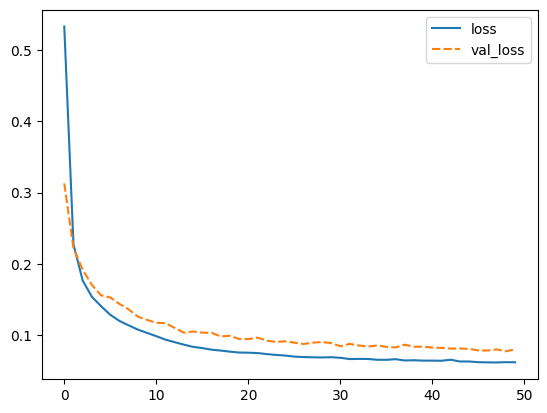

In [11]:
import seaborn as sns
sns.lineplot(model.history.history)

In [12]:
predictions = model.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)

threshold = np.percentile(mse, 95)  # Adjust the percentile as needed
threshold

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


np.float64(0.20607569634201017)

In [13]:
anomalies = mse > threshold

In [14]:
num_anomalies = np.sum(anomalies)
print(f"Number of Anomalies: {num_anomalies}")

Number of Anomalies: 50


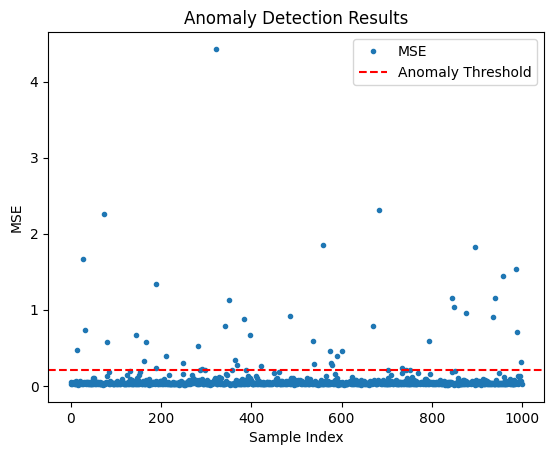

In [15]:
#Plot the anomalies
import matplotlib.pyplot as plot

plt.plot(mse, marker='o', linestyle='', markersize=3, label='MSE')
plt.axhline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.xlabel('Sample Index')
plt.ylabel('MSE')
plt.title('Anomaly Detection Results')
plt.legend()
plt.show()

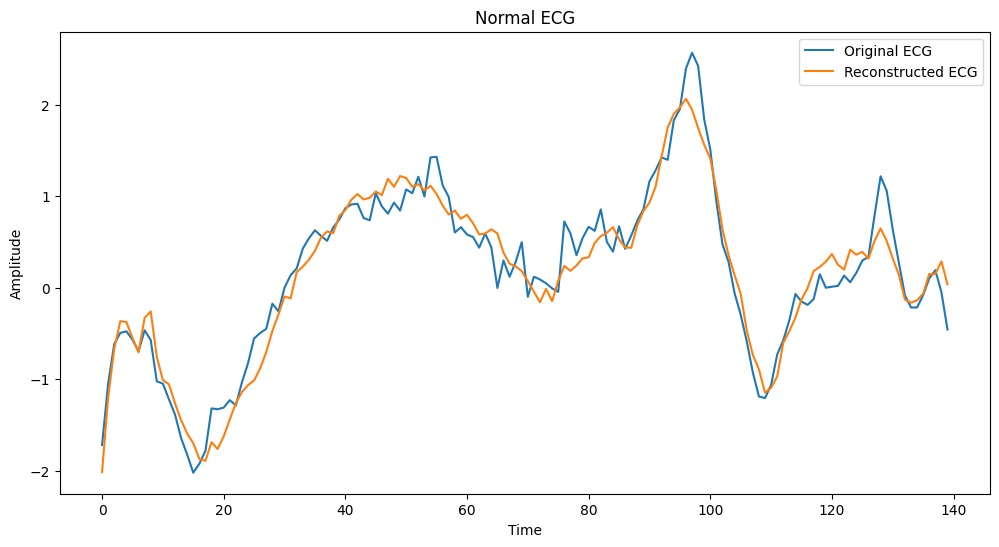

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(x_test[0], label='Original ECG')
plt.plot(predictions[0], label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Normal ECG')
plt.show()

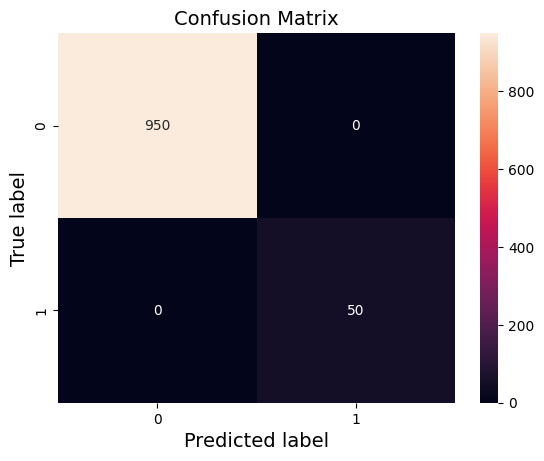

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

sns.heatmap(confusion_matrix(anomalies, anomalies), annot = True, fmt = 'd')
plt.xlabel("Predicted label", fontsize = 14)
plt.ylabel("True label", fontsize = 14)
plt.title("Confusion Matrix", fontsize = 14)
plt.show()